In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
%cd ..

/home/nassim/dev/conrl


In [7]:
from src.conrl import ConRL
from src.qlearning import QLearningAgent
from src.mlgng import MultiLayerGrowingNeuralGas
from src.utils import EpisodeStats
from envs.gridworld import GridworldEnv

import itertools
import numpy as np
import pandas as pd
import sys
import graph_tool.all as gt

In [9]:
env = GridworldEnv(shape=[8, 8])
num_episodes = 100
max_step = 1000
stats = EpisodeStats(
        episode_lengths=np.zeros(num_episodes),
        episode_rewards=np.zeros(num_episodes),
        selector_dist=None)

q_agent = QLearningAgent(action_size=env.action_space.n, state_grid=[np.arange(env.observation_space.n-1)], gamma=0.5, alpha=1)


In [10]:
for i_episode in range(num_episodes):

    if (i_episode + 1) % 50 == 0:
        print("\rEpisode {}/{}.".format(i_episode + 1, num_episodes), end="")
        sys.stdout.flush()
    
    # Generate episode
    state = env.reset()
    state = (state, )
    for step in itertools.count():
        action = q_agent.policy(state)
        next_state, reward, done, _ = env.step(action)
        next_state = (next_state, )
        q_agent.update(state, next_state, action, reward)

        # Update statistics
        stats.episode_rewards[i_episode] += reward
        stats.episode_lengths[i_episode] = step

        if done or step > max_step:
            break
        state = next_state

Episode 100/100.

In [11]:
# Parameters
params = {
    "ndim": 1, 
    "e_w":0.5, 
    "e_n":0.1, 
    "l":10, 
    "a":0.5, 
    "b":0.05, 
    "k":1000.0, 
    "max_nodes":8, 
    "max_age":10
}

num_episodes = 100
max_step = 1000
stats_conrl = EpisodeStats(
        episode_lengths=np.zeros(num_episodes),
        episode_rewards=np.zeros(num_episodes),
        selector_dist=np.zeros((num_episodes, max_step)))

conrl = ConRL(action_size=env.action_space.n, state_grid=[np.arange(env.observation_space.n-1)], ndim=params["ndim"], update_threshold=3)
conrl.mlgng.set_layers_parameters(params, m=-1)


In [1]:
for i_episode in range(num_episodes):

    if (i_episode + 1) % 50 == 0:
        print("\rEpisode {}/{}.".format(i_episode + 1, num_episodes), end="")
        sys.stdout.flush()
    
    # Generate episode
    state = env.reset()
    #state = (state, )
    for step in itertools.count():
        next_state, reward, done, selected = conrl.step(state, env)
        
        # Update statistics
        stats_conrl.episode_rewards[i_episode] += reward
        stats_conrl.episode_lengths[i_episode] = step
        stats_conrl.selector_dist[i_episode][step] = selected

        if done or step > max_step:
            break

        state = next_state


NameError: name 'num_episodes' is not defined

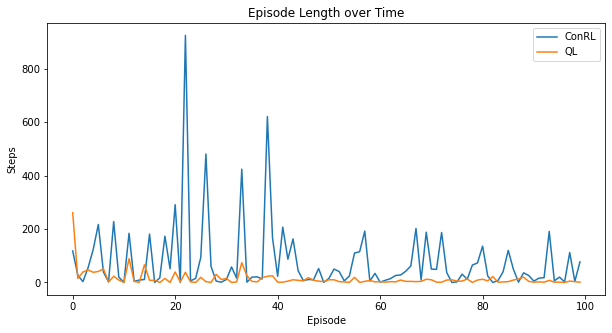

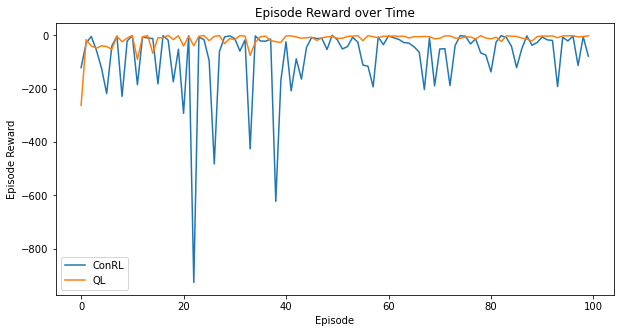

In [16]:
import matplotlib.pyplot as plt
%matplotlib inline

fig1 = plt.figure(figsize=(10,5))
plt.plot(stats_conrl.episode_lengths, label='ConRL')
plt.plot(stats.episode_lengths, label='QL')
plt.xlabel("Episode")
plt.ylabel("Steps")
plt.title("Episode Length over Time")
plt.legend()

fig2 = plt.figure(figsize=(10,5))
plt.plot(stats_conrl.episode_rewards, label='ConRL')
plt.plot(stats.episode_rewards,  label='QL')
plt.xlabel("Episode")
plt.ylabel("Episode Reward")
plt.title("Episode Reward over Time")
plt.legend()

In [ ]:
def plot_q_table(q_table):
    """Visualize max Q-value for each state and corresponding action."""
    q_image = np.max(q_table, axis=2)       # max Q-value for each state
    q_actions = np.argmax(q_table, axis=2)  # best action for each state

    fig, ax = plt.subplots(figsize=(10, 10))
    cax = ax.imshow(q_image, cmap='jet')
    cbar = fig.colorbar(cax)
    for x in range(q_image.shape[0]):
        for y in range(q_image.shape[1]):
            ax.text(x, y, q_actions[x, y], color='white',
                    horizontalalignment='center', verticalalignment='center')
    ax.grid(False)
    ax.set_title("Q-table, size: {}".format(q_table.shape))
    ax.set_xlabel('position')
    ax.set_ylabel('velocity')


plot_q_table(q_agent.Q)

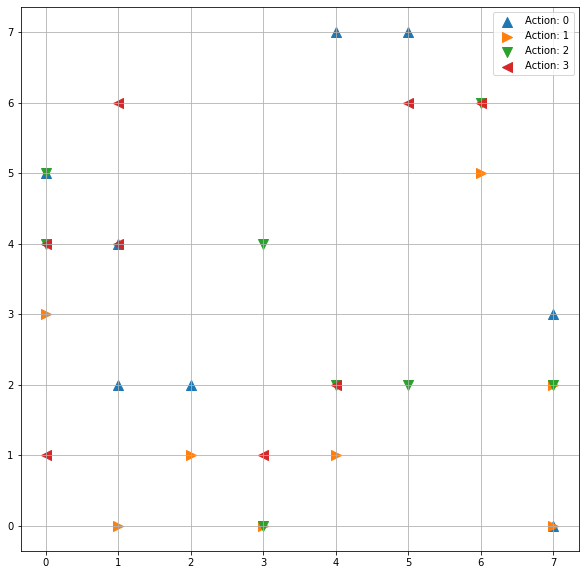

In [18]:
act_dict = {
    0:  "^",
    1: ">",
    2: "v",
    3: "<"
}

fig, ax = plt.subplots(figsize=(10, 10))
# Plot discretization as a grid
ax.grid(True)
for i in range(4):
    x, y = np.unravel_index(conrl.mlgng[i].g.vp.pos.get_2d_array(pos=[0]).astype(int), [8, 8])
    ax.scatter(x, y, label='Action: {}'.format(i), marker=act_dict[i], s=10**2)
    ax.legend()


In [19]:
conrl.mlgng.stats()

> Layer:  0
Iterations:  1180
Graph properties: 
<Graph object, undirected, with 8 vertices and 7 edges, 4 internal vertex properties, 1 internal edge property, at 0x7f825456ee80>
> Layer:  1
Iterations:  710
Graph properties: 
<Graph object, undirected, with 8 vertices and 5 edges, 4 internal vertex properties, 1 internal edge property, at 0x7f8254537208>
> Layer:  2
Iterations:  1265
Graph properties: 
<Graph object, undirected, with 8 vertices and 6 edges, 4 internal vertex properties, 1 internal edge property, at 0x7f8254537470>
> Layer:  3
Iterations:  1239
Graph properties: 
<Graph object, undirected, with 8 vertices and 6 edges, 4 internal vertex properties, 1 internal edge property, at 0x7f8254537748>


Text(0, 0.5, 'Agent')

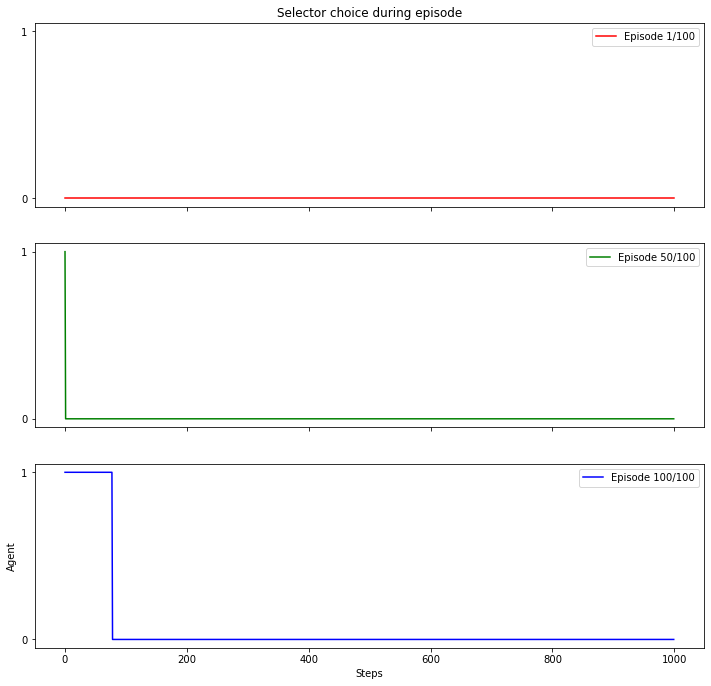

In [20]:
fig, ax = plt.subplots(3, 1, sharex=True, sharey=True, figsize=(12, 11.5))

ax[0].plot(stats_conrl.selector_dist[0], color="r", label="Episode 1/100")
ax[0].legend()
ax[1].plot(stats_conrl.selector_dist[49], color="g", label="Episode 50/100")

ax[1].legend()
ax[2].plot(stats_conrl.selector_dist[99], color="b", label="Episode 100/100")
ax[2].legend()

ax[0].set_title("Selector choice during episode")
plt.yticks([0, 1])
plt.xlabel("Steps")
plt.ylabel("Agent")

In [26]:
states = np.arange(8*8)
actions = np.zeros(8*8)
for state in states:
    actions[state], _, _, _ = conrl._simple_action_selector(state)

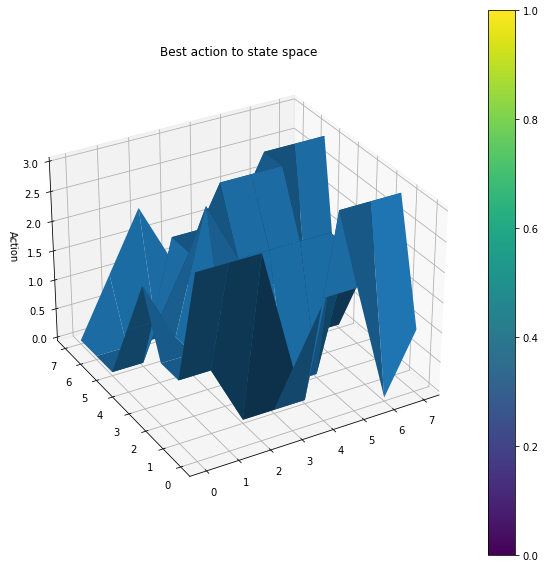

In [23]:
x_range = y_range = np.arange(0, 8)
X, Y = np.meshgrid(x_range, y_range)

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(X, Y, actions.reshape((4,4)), rstride=1, cstride=1, vmin=-1.0, vmax=1.0)
ax.set_zlabel('Action')
ax.set_title("Best action to state space")
ax.view_init(ax.elev, -120)
fig.colorbar(surf)
fig.tight_layout()
plt.show()

In [28]:
from collections import defaultdict

states = np.arange(8*8)
state_actions = defaultdict(lambda: [])
for state in states:
    best_a, _, _, _ = conrl._simple_action_selector(state)
    state_actions[best_a].append(state)

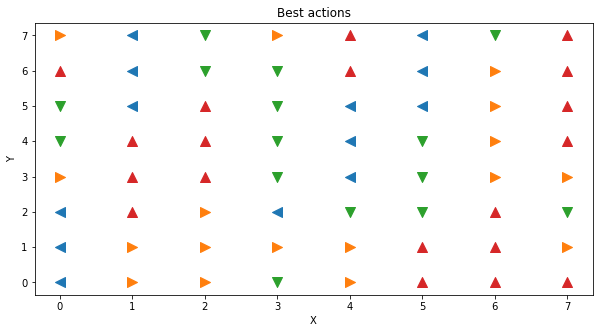

In [30]:
act_dict = {
    0:  "^",
    1: ">",
    2: "v",
    3: "<"
}

fig = plt.figure(figsize=(10,5))

for k, v in state_actions.items():
    x, y = np.unravel_index(v, (8,8))
    plt.scatter(x, y, label='Action: {}'.format(k), marker=act_dict[k], s=10**2)
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.title("Best actions")